In [2]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter

/Users/akbarpathan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Define the list of tickers for the selected equities
tickers = ['CRWD', 'NVDA', 'HD']

# Initialize an empty dictionary to store the data
data = {}

# Retrieve 2-minute interval data for the past 60 days
start_date = (datetime.datetime.now() - datetime.timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

for ticker in tickers:
    print(f"Fetching data for {ticker}")
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval='2m')
        data[ticker] = stock_data
        
        # Save each stock's data into a separate CSV file
        stock_data.to_csv(f"{ticker}_2min_data.csv")
        
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

print("Data retrieval and saving complete!")

Fetching data for CRWD


[*********************100%%**********************]  1 of 1 completed


Fetching data for NVDA


[*********************100%%**********************]  1 of 1 completed


Fetching data for HD


[*********************100%%**********************]  1 of 1 completed

Data retrieval and saving complete!


In [3]:
# Load the previously saved CRWD data
crwd_data = pd.read_csv("CRWD_2min_data.csv", index_col=0, parse_dates=True)

# Check the first few rows of the data to ensure it loaded correctly
print("Initial data check:")
print(crwd_data.head())

# Calculate the 20-minute and 200-minute SMAs
crwd_data['20min_SMA'] = crwd_data['Close'].rolling(window=10).mean()  # 20min SMA on a 2min interval is a 10-period SMA
crwd_data['200min_SMA'] = crwd_data['Close'].rolling(window=100).mean()  # 200min SMA on a 2min interval is a 100-period SMA

# Check if the SMA columns are populated correctly
if crwd_data['20min_SMA'].isnull().all() or crwd_data['200min_SMA'].isnull().all():
    print("Error: SMA columns are not populated correctly. Please check the calculations.")
else:
    print("SMA columns populated successfully. Sample data:")
    print(crwd_data[['20min_SMA', '200min_SMA']].dropna().head())

# Save the updated data with SMAs to the same CSV file or a new one
crwd_data.to_csv("CRWD_2min_data_with_SMA.csv")

print("Process completed successfully! 20min & 200min SMA data added to CSV file!")

Initial data check:
                                 Open        High         Low       Close  \
Datetime                                                                    
2024-07-08 09:30:00-04:00  390.368011  397.038086  390.279999  395.589996   
2024-07-08 09:32:00-04:00  395.704987  396.899994  394.220001  394.220001   
2024-07-08 09:34:00-04:00  394.100006  394.334991  383.670013  386.410004   
2024-07-08 09:36:00-04:00  385.619995  385.619995  379.790009  382.119995   
2024-07-08 09:38:00-04:00  382.434998  385.459900  381.490997  385.230011   

                            Adj Close  Volume  
Datetime                                       
2024-07-08 09:30:00-04:00  395.589996  241134  
2024-07-08 09:32:00-04:00  394.220001   95122  
2024-07-08 09:34:00-04:00  386.410004  176206  
2024-07-08 09:36:00-04:00  382.119995  178854  
2024-07-08 09:38:00-04:00  385.230011   80863  
SMA columns populated successfully. Sample data:
                            20min_SMA  200min_SMA
Datet

In [4]:
# Now add the Setup condition
crwd_data['Setup'] = crwd_data['20min_SMA'] > crwd_data['200min_SMA']

# Save the updated data with the Setup column to the same or new CSV file
crwd_data.to_csv("CRWD_2min_data_with_SMA_and_Setup.csv")

# Re-load the final file to confirm everything saved correctly
final_data = pd.read_csv("CRWD_2min_data_with_SMA_and_Setup.csv", index_col=0, parse_dates=True)

# Check if the SMA and Setup columns are populated in the final CSV
if final_data[['20min_SMA', '200min_SMA', 'Setup']].isnull().all().any():
    print("Error: One or more columns (SMA, Setup) are not populated correctly in the final CSV.")
else:
    print("Final CSV file saved correctly. Sample data:")
    print(final_data[['20min_SMA', '200min_SMA', 'Setup']].dropna().head())

print("Process completed successfully! First portion of setup with identifying Picture of Power is complete!")

Final CSV file saved correctly. Sample data:
                            20min_SMA  200min_SMA  Setup
Datetime                                                
2024-07-08 12:48:00-04:00  387.350009  387.061303   True
2024-07-08 12:50:00-04:00  387.349509  386.981053   True
2024-07-08 12:52:00-04:00  387.392209  386.917353   True
2024-07-08 12:54:00-04:00  387.464410  386.932753   True
2024-07-08 12:56:00-04:00  387.566412  386.992253   True
Process completed successfully! First portion of setup with identifying Picture of Power is complete!


In [5]:
# Load the CRWD data with SMAs and Setup
crwd_data = pd.read_csv("CRWD_2min_data_with_SMA_and_Setup.csv", index_col=0, parse_dates=True)

# Initialize all bars as "Noise Bar" by default
crwd_data['Label'] = "Noise Bar"

# Identify Control Bars
crwd_data.loc[(crwd_data['Close'] > crwd_data['Open']) & (crwd_data['Setup'] == True), 'Label'] = "Control Bar"

# Iterate through the DataFrame to label Ignored Bars and Indicator Bars
for i in range(1, len(crwd_data) - 1):
    if crwd_data.iloc[i]['Label'] == "Control Bar":
        # We have identified a Control Bar; now check subsequent bars

        # Check for Ignored Bar A
        if (crwd_data.iloc[i + 1]['Close'] < crwd_data.iloc[i + 1]['Open']) and \
           ((crwd_data.iloc[i + 1]['Open'] - crwd_data.iloc[i + 1]['Close']) <= 0.5 * (crwd_data.iloc[i]['Close'] - crwd_data.iloc[i]['Open'])):
            crwd_data.iloc[i + 1, crwd_data.columns.get_loc('Label')] = "Ignored Bar A"

            # Check for Ignored Bar B
            if (i + 2 < len(crwd_data)) and \
               (crwd_data.iloc[i + 2]['Close'] < crwd_data.iloc[i + 2]['Open']) and \
               ((crwd_data.iloc[i + 2]['Open'] - crwd_data.iloc[i + 2]['Close']) <= 0.5 * (crwd_data.iloc[i]['Close'] - crwd_data.iloc[i]['Open'])):
                crwd_data.iloc[i + 2, crwd_data.columns.get_loc('Label')] = "Ignored Bar B"
                next_index = i + 2
            else:
                next_index = i + 1
            
            # Check for Indicator Bar
            if (next_index + 1 < len(crwd_data)) and \
               (crwd_data.iloc[next_index + 1]['Close'] > crwd_data.iloc[next_index + 1]['Open']) and \
               (crwd_data.iloc[next_index + 1]['High'] > crwd_data.iloc[next_index]['High']):
                crwd_data.iloc[next_index + 1, crwd_data.columns.get_loc('Label')] = "Indicator Bar"

# Final Review: Relabel any "Control Bar" that is not followed by an "Ignored Bar" as a "Noise Bar"
for i in range(len(crwd_data) - 1):
    if crwd_data.iloc[i]['Label'] == "Control Bar":
        if crwd_data.iloc[i + 1]['Label'] not in ["Ignored Bar A", "Ignored Bar B"]:
            crwd_data.iloc[i, crwd_data.columns.get_loc('Label')] = "Noise Bar"

# Save the labeled data to a new CSV file
crwd_data.to_csv("CRWD_2min_data_with_Final_Labels.csv")

print("Candlestick labeling completed and saved successfully!")


Candlestick labeling completed and saved successfully!


In [6]:
# Load the CRWD data with final labels
crwd_data = pd.read_csv("CRWD_2min_data_with_Final_Labels.csv", index_col=0, parse_dates=True)

# Calculate the slope (first derivative) of the 20-minute SMA
crwd_data['SMA_20_slope'] = crwd_data['20min_SMA'].diff()

# Initialize all bars as "Empty"
crwd_data['Trade_Status'] = "Empty"

# Check the conditions after identifying Ignored Bars
for i in range(len(crwd_data) - 1):
    if crwd_data.iloc[i]['Label'] in ["Ignored Bar A", "Ignored Bar B"]:
        # Condition 1: Check if the closing price is within $1.00 of the 20-minute SMA
        proximity_condition = abs(crwd_data.iloc[i]['Close'] - crwd_data.iloc[i]['20min_SMA']) <= 1.00
        
        # Condition 2: Check if the slope of the 20-minute SMA is positive
        slope_condition = crwd_data.iloc[i]['SMA_20_slope'] > 0
        
        # If both conditions are true, label the bar as "Primed"
        if proximity_condition and slope_condition:
            crwd_data.iloc[i, crwd_data.columns.get_loc('Trade_Status')] = "Primed"

# Save the updated data with the Trade_Status column to a new CSV file
crwd_data.to_csv("CRWD_2min_data_with_Trade_Status.csv")

print("Proximity and slope checks completed, and labels applied successfully!")


Proximity and slope checks completed, and labels applied successfully!


In [7]:
# Load the data from CRWD_2min_data_with_Trade_Status.csv
crwd_data = pd.read_csv("CRWD_2min_data_with_Trade_Status.csv", index_col=0, parse_dates=True)

# Round all numerical values to the nearest thousandth and format to three decimal places
for column in crwd_data.select_dtypes(include=['float64', 'int64']).columns:
    crwd_data[column] = crwd_data[column].round(3).apply(lambda x: f"{x:.3f}")

# Save the cleaned-up data back to the CSV file
crwd_data.to_csv("CRWD_2min_data_with_Trade_Status_cleaned.csv")

print("CRWD_2min_data_with_Trade_Status.csv has been cleaned and saved as CRWD_2min_data_with_Trade_Status_cleaned.csv.")

CRWD_2min_data_with_Trade_Status.csv has been cleaned and saved as CRWD_2min_data_with_Trade_Status_cleaned.csv.


In [8]:
# Load the CRWD data with the latest labels
crwd_data = pd.read_csv("CRWD_2min_data_with_Trade_Status.csv", index_col=0, parse_dates=True)

# Initialize a DataFrame to record trades
trade_log = pd.DataFrame(columns=["Entry_Time", "Action_Price", "Stop_Loss", "Trade_Type", "Trade_ID"])

# Create a list to track active positions with Trade IDs
active_positions = []

# Function to find the most recent Ignored Bar and calculate the stop loss
def calculate_stop_loss(index):
    recent_ignored_bar_index = index - 1
    while recent_ignored_bar_index >= 0 and crwd_data.iloc[recent_ignored_bar_index]['Label'] not in ["Ignored Bar A", "Ignored Bar B"]:
        recent_ignored_bar_index -= 1
    stop_loss = crwd_data.iloc[recent_ignored_bar_index]['Low'] - 0.01
    return stop_loss

# Unique Trade ID generator
trade_id_counter = 1

# Iterate through the DataFrame to identify and execute trades
for i in range(1, len(crwd_data) - 1):
    current_open = crwd_data.iloc[i]['Open']
    current_high = crwd_data.iloc[i]['High']
    current_low = crwd_data.iloc[i]['Low']
    current_close = crwd_data.iloc[i]['Close']
    current_sma = crwd_data.iloc[i]['20min_SMA']
    
    # Check for each active position
    for position in active_positions[:]:  # Use a copy of the list to modify it during iteration
        entry_time, entry_price, stop_loss, trade_type, trade_id = position
        
        # Check for stop loss first, by comparing the low price
        if current_low <= stop_loss:
            action_price = stop_loss  # Sell at the stop loss price
            # Log the sell due to stop loss
            trade_log = pd.concat([trade_log, pd.DataFrame({
                "Entry_Time": [crwd_data.index[i]],
                "Action_Price": [action_price],
                "Stop_Loss": [stop_loss],
                "Trade_Type": ["Sell - Stop Loss"],
                "Trade_ID": [trade_id]
            })], ignore_index=True)
            
            # Remove the position from active_positions
            active_positions.remove(position)
            print(f"Position with Trade ID {trade_id} closed due to stop loss at {crwd_data.index[i]}: Sell Price = {action_price}")
        
        else:
            # Now check for SMA divergence
            sma_diff = current_sma - current_close
            
            if sma_diff > 0:  # SMA is above the current price (positive difference)
                prices_to_check = [current_low, current_close, current_open, current_high]
            else:  # SMA is below the current price (negative difference)
                prices_to_check = [current_high, current_open, current_close, current_low]
            
            # Find the first price that diverges more than the threshold
            for price in prices_to_check:
                if abs(price - current_sma) >= 1.00:
                    action_price = price
                    # Log the sell due to SMA divergence
                    trade_log = pd.concat([trade_log, pd.DataFrame({
                        "Entry_Time": [crwd_data.index[i]],
                        "Action_Price": [action_price],
                        "Stop_Loss": [stop_loss],
                        "Trade_Type": ["Sell - Away from SMA"],
                        "Trade_ID": [trade_id]
                    })], ignore_index=True)
                    
                    # Remove the position from active_positions
                    active_positions.remove(position)
                    print(f"Position with Trade ID {trade_id} closed due to SMA divergence at {crwd_data.index[i]}: Sell Price = {action_price}")
                    break  # Exit the loop once a price meets the condition

    # Check if a new position was opened (from the previous logic)
    if crwd_data.iloc[i]['Label'] == "Indicator Bar" and \
       crwd_data.iloc[i]['Close'] > crwd_data.iloc[i-1]['High'] + 0.01:
        # Calculate the stop loss as $0.01 below the last Ignored Bar
        stop_loss = calculate_stop_loss(i)
        
        # Record the new buy position with a unique Trade ID
        trade_id = trade_id_counter
        new_position = (
            crwd_data.index[i],  # Entry time
            crwd_data.iloc[i-1]['High'] + 0.01,  # Entry price
            stop_loss,  # Stop loss
            "Buy",  # Trade type
            trade_id  # Trade ID
        )
        active_positions.append(new_position)
        
        # Log the buy
        trade_log = pd.concat([trade_log, pd.DataFrame({
            "Entry_Time": [crwd_data.index[i]],
            "Action_Price": [crwd_data.iloc[i-1]['High'] + 0.01],
            "Stop_Loss": [stop_loss],
            "Trade_Type": ["Buy"],
            "Trade_ID": [trade_id]
        })], ignore_index=True)

        # Increment the Trade ID counter
        trade_id_counter += 1

# Save the trade log to a new CSV file
trade_log.to_csv("CRWD_Trade_Log.csv", index=False)

print("Trade identification and logging completed successfully!")


Position with Trade ID 1 closed due to stop loss at 2024-07-08 13:50:00-04:00: Sell Price = 387.6399938964844
Position with Trade ID 2 closed due to SMA divergence at 2024-07-08 15:54:00-04:00: Sell Price = 390.9984130859375
Position with Trade ID 3 closed due to stop loss at 2024-07-10 14:18:00-04:00: Sell Price = 372.6300146484375
Position with Trade ID 4 closed due to SMA divergence at 2024-07-10 15:34:00-04:00: Sell Price = 373.7000122070313
Position with Trade ID 5 closed due to stop loss at 2024-07-12 10:58:00-04:00: Sell Price = 372.29999755859376
Position with Trade ID 6 closed due to stop loss at 2024-07-12 11:58:00-04:00: Sell Price = 369.2899877929687
Position with Trade ID 7 closed due to stop loss at 2024-07-12 15:30:00-04:00: Sell Price = 372.1699926757813
Position with Trade ID 8 closed due to SMA divergence at 2024-07-15 09:58:00-04:00: Sell Price = 378.3800048828125
Position with Trade ID 9 closed due to SMA divergence at 2024-07-15 10:20:00-04:00: Sell Price = 379.890

/var/folders/2n/rmtzbdn93h3f2tkgn0yypj300000gn/T/ipykernel_37479/1424102000.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trade_log = pd.concat([trade_log, pd.DataFrame({


Position with Trade ID 13 closed due to stop loss at 2024-07-15 15:36:00-04:00: Sell Price = 378.6550085449219
Position with Trade ID 12 closed due to stop loss at 2024-07-15 15:38:00-04:00: Sell Price = 378.5399877929687
Position with Trade ID 14 closed due to SMA divergence at 2024-07-17 14:22:00-04:00: Sell Price = 357.2799987792969
Position with Trade ID 15 closed due to stop loss at 2024-07-17 15:32:00-04:00: Sell Price = 357.29999755859376
Position with Trade ID 16 closed due to SMA divergence at 2024-07-23 11:02:00-04:00: Sell Price = 271.3500061035156
Position with Trade ID 17 closed due to SMA divergence at 2024-07-23 11:12:00-04:00: Sell Price = 273.2250061035156
Position with Trade ID 18 closed due to stop loss at 2024-07-24 13:46:00-04:00: Sell Price = 263.71000122070313
Position with Trade ID 19 closed due to SMA divergence at 2024-07-25 13:04:00-04:00: Sell Price = 260.1098937988281
Position with Trade ID 20 closed due to stop loss at 2024-07-26 13:34:00-04:00: Sell Price

In [9]:
# Load the existing trade log
trade_log = pd.read_csv("CRWD_Trade_Log.csv", parse_dates=["Entry_Time"])

# Sort the trade log by Entry_Time in ascending order
trade_log = trade_log.sort_values(by="Entry_Time", ascending=True)

# Round all monetary values to the nearest hundredth and format to keep two decimal places
trade_log["Action_Price"] = trade_log["Action_Price"].round(2).apply(lambda x: f"{x:.2f}")
trade_log["Stop_Loss"] = trade_log["Stop_Loss"].round(2).apply(lambda x: f"{x:.2f}")

# Save the updated and sorted trade log
trade_log.to_csv("CRWD_Trade_Log.csv", index=False)

print("Trade log sorted, rounded, and formatted with two decimal places successfully!")

Trade log sorted, rounded, and formatted with two decimal places successfully!


In [3]:
# Load the CRWD trade log
trade_log = pd.read_csv("CRWD_Trade_Log.csv", parse_dates=["Entry_Time"])

# Initialize variables for the performance log
initial_cash = 100000.00
cash = initial_cash
equity_curve = [cash]  # Track the equity curve for max drawdown calculation
ticker = "CRWD"

# Initialize a DataFrame to record performance
performance_log = pd.DataFrame(columns=["Trade_ID", "Action_Type", "Ticker", "Action_Time", "Action_Price", "Shares", "Total_Action_Value", "Cash_After_Trade", "Value_of_Open_Positions", "Value_of_Fund", "Simple_Return", "R_Multiple"])

# Track the number of shares held for each trade ID
positions = {}

# Iterate through the trade log to simulate the strategy
for i, row in trade_log.iterrows():
    trade_id = row["Trade_ID"]
    action_price = round(row["Action_Price"], 2)
    action_time = row["Entry_Time"].strftime("%Y-%m-%d %H:%M:%S")
    trade_type = row["Trade_Type"]

    if "Buy" in trade_type:
        # Calculate the amount to spend (half of current cash)
        amount_to_spend = cash / 2

        # Calculate the number of shares to buy, rounded down to the nearest hundredth
        shares = math.floor((amount_to_spend / action_price) * 100) / 100
        
        # Calculate the total purchase price, rounded to the nearest hundredth
        total_purchase_price = round(shares * action_price, 2)

        # Ensure we have more than $1 to trade with
        if total_purchase_price > 1.00:
            # Record the position
            positions[trade_id] = (shares, action_price, row["Stop_Loss"])

            # Update cash
            cash -= total_purchase_price

            # Calculate the value of all open positions
            value_of_open_positions = sum(
                (shares_held * action_price) for _, (shares_held, entry_price, _) in positions.items()
            )

            # Total value of the fund (cash + value of open positions)
            value_of_fund = cash + value_of_open_positions

            # Log the buy action
            performance_log = pd.concat([performance_log, pd.DataFrame({
                "Trade_ID": [trade_id],
                "Action_Type": ["Buy"],
                "Ticker": [ticker],
                "Action_Time": [action_time],
                "Action_Price": [f"{action_price:.2f}"],
                "Shares": [f"{shares:.2f}"],
                "Total_Action_Value": [f"{total_purchase_price:.2f}"],
                "Cash_After_Trade": [f"{cash:.2f}"],
                "Value_of_Open_Positions": [f"{value_of_open_positions:.2f}"],
                "Value_of_Fund": [f"{value_of_fund:.2f}"],
                "Simple_Return": [None],  # Simple return is not applicable at the time of buy
                "R_Multiple": [None]  # R-multiple is not applicable at the time of buy
            })], ignore_index=True)
    
    elif "Sell" in trade_type and trade_id in positions:
        # Calculate the number of shares to sell and retrieve the buy price and stop loss
        shares, entry_price, stop_loss = positions.pop(trade_id)
        
        # Calculate the total sale price, rounded to the nearest hundredth
        total_sale_price = round(shares * action_price, 2)

        # Correct R-multiple calculation:
        if entry_price != stop_loss:
            r_multiple = round((action_price - entry_price) / (entry_price - stop_loss), 2)
        else:
            r_multiple = -1.00  # If stop loss is exactly hit

        # Update cash
        cash += total_sale_price  # ADD the sale proceeds to the cash balance
        equity_curve.append(cash)

        # Calculate the value of all open positions
        value_of_open_positions = sum(
            (shares_held * action_price) for _, (shares_held, entry_price, _) in positions.items()
        )

        # Total value of the fund (cash + value of open positions)
        value_of_fund = cash + value_of_open_positions

        # Calculate the simple return for this trade
        trade_simple_return = round(((total_sale_price - (shares * entry_price)) / (shares * entry_price)) * 100, 3)

        # Log the sell action
        performance_log = pd.concat([performance_log, pd.DataFrame({
                "Trade_ID": [trade_id],
                "Action_Type": ["Sell"],
                "Ticker": [ticker],
                "Action_Time": [action_time],
                "Action_Price": [f"{action_price:.2f}"],
                "Shares": [f"{shares:.2f}"],
                "Total_Action_Value": [f"{total_sale_price:.2f}"],
                "Cash_After_Trade": [f"{cash:.2f}"],
                "Value_of_Open_Positions": [f"{value_of_open_positions:.2f}"],
                "Value_of_Fund": [f"{value_of_fund:.2f}"],
                "Simple_Return": [f"{trade_simple_return:.2f}%"],
                "R_Multiple": [f"{r_multiple:.2f}"]
            })], ignore_index=True)

# Close any open positions at the end of the log
for trade_id, (shares, entry_price, stop_loss) in positions.items():
    # Close at the entry price
    action_price = entry_price
    
    # Calculate the total sale price, rounded to the nearest hundredth
    total_sale_price = round(shares * action_price, 2)
    
    # No R-multiple for closing at the entry price, it's break-even
    r_multiple = 0

    # Update cash
    cash += total_sale_price  # ADD the sale proceeds to the cash balance
    equity_curve.append(cash)

    # Calculate the value of all open positions
    value_of_open_positions = sum(
        (shares_held * action_price) for _, (shares_held, entry_price, _) in positions.items()
    )

    # Total value of the fund (cash + value of open positions)
    value_of_fund = cash + value_of_open_positions

    # Calculate the simple return for this trade
    trade_simple_return = round(((total_sale_price - (shares * entry_price)) / (shares * entry_price)) * 100, 3)

    # Log the sell action for closing open positions
    performance_log = pd.concat([performance_log, pd.DataFrame({
                "Trade_ID": [trade_id],
                "Action_Type": ["Sell - End of Log"],
                "Ticker": [ticker],
                "Action_Time": [trade_log.iloc[-1]["Entry_Time"].strftime("%Y-%m-%d %H:%M:%S")],
                "Action_Price": [f"{action_price:.2f}"],
                "Shares": [f"{shares:.2f}"],
                "Total_Action_Value": [f"{total_sale_price:.2f}"],
                "Cash_After_Trade": [f"{cash:.2f}"],
                "Value_of_Open_Positions": [f"{value_of_open_positions:.2f}"],
                "Value_of_Fund": [f"{value_of_fund:.2f}"],
                "Simple_Return": [f"{trade_simple_return:.2f}%"],
                "R_Multiple": [f"{r_multiple:.2f}"]
            })], ignore_index=True)

# Save the updated performance log to a new CSV file
performance_log.to_csv("Performance_Log.csv", index=False)

print("Trading execution and logging with Solution 2 implemented completed successfully!")


Trading execution and logging with Solution 2 implemented completed successfully!


In [18]:
# Load the performance log
performance_log = pd.read_csv("Performance_Log.csv")

# Initialize variables for performance metrics
initial_cash = 100000.00
final_cash = performance_log.iloc[-1]["Cash_After_Trade"]
total_profit = 0.00
total_loss = 0.00
num_wins = 0
num_losses = 0
log_returns = []
equity_curve = performance_log["Value_of_Fund"]

# Iterate through the performance log to calculate metrics
for i, row in performance_log.iterrows():
    if "Sell" in row["Action_Type"]:
        entry_price = float(performance_log[(performance_log["Trade_ID"] == row["Trade_ID"]) & (performance_log["Action_Type"] == "Buy")]["Action_Price"].iloc[0])
        action_price = float(row["Action_Price"])
        
        # Calculate log return and append to log_returns
        log_return = np.log(action_price / entry_price)
        log_returns.append(log_return)

        # Determine if this is a winning or losing trade
        if log_return > 0:
            total_profit += float(row["Total_Action_Value"]) - entry_price * float(row["Shares"])
            num_wins += 1
        else:
            total_loss += entry_price * float(row["Shares"]) - float(row["Total_Action_Value"])
            num_losses += 1

# Calculate metrics
full_trades = num_wins + num_losses
win_rate = round((num_wins / full_trades) * 100, 3) if full_trades > 0 else 0
profit_factor = round((total_profit / total_loss), 3) if total_loss > 0 else float('inf')
simple_return = round((final_cash - initial_cash) / initial_cash * 100, 3)

# Calculate the realized Rf return for the specific period
annual_rate = 5.35 / 100  # Convert 5.35% to a decimal
days_held = 43  # Number of days between 07/08/2024 and 08/19/2024
days_in_year = 365  # Number of days in a year

# Calculate cumulative Rf over the period
realized_Rf_return = ((1 + annual_rate) ** (days_held / days_in_year) - 1)

# Calculate the total log return of the portfolio over the period
total_log_return = np.sum(log_returns)

# Calculate the Sharpe Ratio using the total log return and cumulative Rf return
log_return_std = np.std(log_returns)
sharpe_ratio = round((total_log_return - realized_Rf_return) / log_return_std, 3) if len(log_returns) > 1 else 0

# Calculate Max Drawdown using the Value_of_Fund column
roll_max = equity_curve.cummax()
drawdown = (equity_curve - roll_max) / roll_max
max_drawdown = round(drawdown.min() * -100, 3) if not drawdown.empty else 0

# Output final metrics and cash balance
pnl = final_cash - initial_cash
pnl_sign = "+" if pnl > 0 else "-"

print(f"Full Trades: {full_trades}")
print(f"Win Rate: {win_rate}%")
print(f"Total Simple Return: {simple_return}%")
print(f"Total Log Return: {round(total_log_return*100,3)}%")
print(f"Profit Factor: {profit_factor}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}%")
print(f"Total P&L: {pnl_sign}${pnl:,.2f}")

0.07517354874411956
Full Trades: 60
Win Rate: 45.0%
Total Simple Return: 3.702%
Total Log Return: 7.517%
Profit Factor: 2.487
Sharpe Ratio: 19.126
Max Drawdown: 0.676%
Total P&L: +$3,702.26


/var/folders/2n/rmtzbdn93h3f2tkgn0yypj300000gn/T/ipykernel_18989/1259271194.py:54: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend.legendHandles:


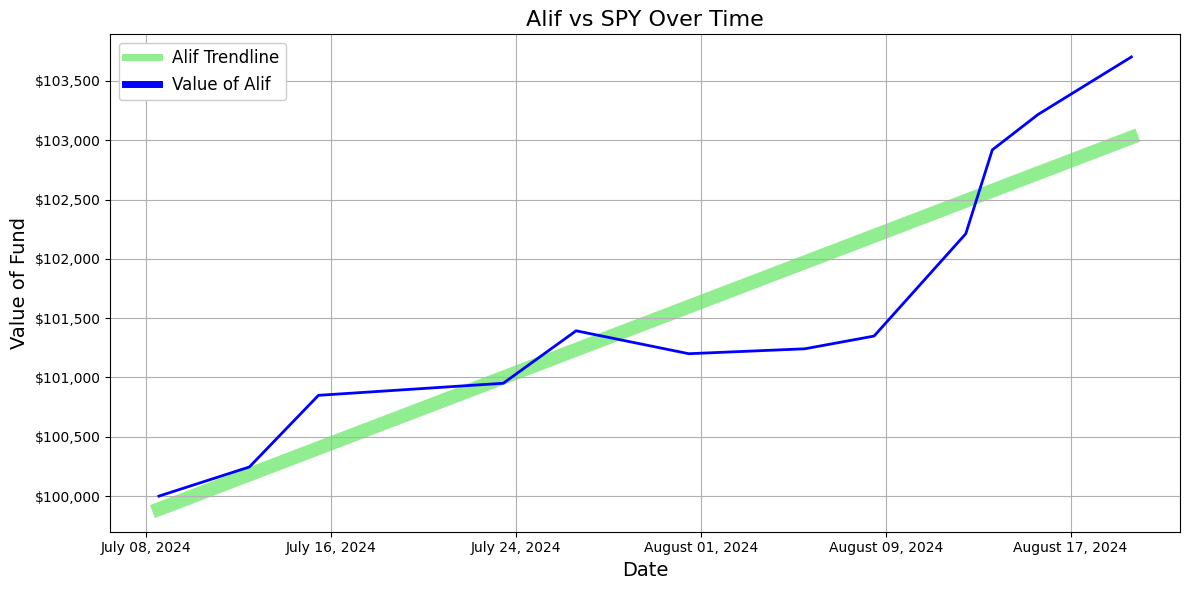

In [22]:
# Load the performance log
performance_log = pd.read_csv("Performance_Log.csv", parse_dates=["Action_Time"])

# Remove duplicate Action_Time entries
performance_log = performance_log.drop_duplicates(subset="Action_Time")

# Determine the number of points to plot
num_points = 12
indices = np.linspace(0, len(performance_log) - 1, num_points, dtype=int)

# Select the data at the calculated indices
selected_data = performance_log.iloc[indices]

# Plot the value of the fund over time
plt.figure(figsize=(12, 6))

# Calculate and plot the line of best fit (trend line) based on the selected data
x = date2num(selected_data["Action_Time"])
y = selected_data["Value_of_Fund"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Plot the Portfolio Trend line under the Value of Fund line
plt.plot(selected_data["Action_Time"], p(x), color='lightgreen', linewidth=10, label='Alif Trendline', zorder=1)

# Enhancing the chart
plt.plot(selected_data["Action_Time"], selected_data["Value_of_Fund"], color='blue', linewidth=2, label='Value of Alif', zorder=2)

plt.title('Alif vs SPY Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value of Fund', fontsize=14)
plt.grid(True)

# Format the date on the x-axis to "Month Day, Year"
date_form = DateFormatter("%B %d, %Y")
plt.gca().xaxis.set_major_formatter(date_form)

# Format the y-axis with dollar signs and commas
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))

# Set evenly spaced gridlines on x-axis
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=7))  # Adjust the number of gridlines on the x-axis

# Adding a legend with better display for the thick line
legend = plt.legend(loc='upper left', fontsize=12)
legend.get_frame().set_alpha(1)  # Make the legend background solid

# Adjust the thickness of the legend line
for legobj in legend.legendHandles:
    legobj.set_linewidth(5.0)

# Show the plot
plt.tight_layout()
plt.show()
